In [2]:
import numpy as np
import pandas as pd
import openml
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2
import linsvm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The dataset used for evaluation is a9a from OpenML. In order to use it with our implementation, we must keep variables and labels in form of numpy arrays.

In [ ]:
a9a_dataset = openml.datasets.get_dataset('a9a')
a9a = a9a_dataset.get_data(dataset_format="dataframe")

y = a9a[0]["class"].to_numpy()
x = a9a[0].drop("class", axis=1).to_numpy()

scale = StandardScaler()
x = scale.fit_transform(x)

In [4]:
permutation = np.random.permutation(range(len(y)))

train_idx = permutation[:int(0.9*len(y))]
test_idx = permutation[1 + int(0.9*len(y)):]

x_train = x[train_idx, :]
y_train = y[train_idx]

x_test = x[test_idx, :]
y_test = y[test_idx]

First, let's run the model with default settings:

In [64]:
SVM = linsvm.LinSVM()
SVM.fit(x_train, y_train, verbose = True)

Iteration: 1
Gradient gap: 235765.7511407619

Iteration: 2
Gradient gap: 6858.105786383345

Iteration: 3
Gradient gap: 44.25789830082767

Iteration: 4
Gradient gap: 15.033940277465955

Iteration: 5
Gradient gap: 9.28710494408323

Iteration: 6
Gradient gap: 8.9332692315643

Iteration: 7
Gradient gap: 9.624413395966013

Iteration: 8
Gradient gap: 9.496800164461417

Iteration: 9
Gradient gap: 8.964232101210198

Iteration: 10
Gradient gap: 8.63676461145886

Iteration: 11
Gradient gap: 9.073710500991531

Iteration: 12
Gradient gap: 9.00731655824461

Iteration: 13
Gradient gap: 8.115252579125354

Iteration: 14
Gradient gap: 9.211728077891792

Iteration: 15
Gradient gap: 9.877122600636937

Iteration: 16
Gradient gap: 9.301049895022384

Iteration: 17
Gradient gap: 9.188031577658538

Iteration: 18
Gradient gap: 8.957012112572379

Iteration: 19
Gradient gap: 8.751505597948487

Iteration: 20
Gradient gap: 8.18515080740665

Iteration: 21
Gradient gap: 8.862150201131922

Iteration: 22
Gradient gap:

In [65]:
prediction = SVM.predict(x_test)
accuracy = np.sum(prediction == y_test)/len(y_test)
print(accuracy)

0.8515561015561015


The model took 3 minutes and 28 seconds to train and achieved 85.2% accuracy on the test set. Let's compare it to the standard scikit-learn implementation based on LIBSVM.

In [66]:
from sklearn.svm import SVC

sklearnSVM = SVC(kernel = "linear", tol = 1e-2)
sklearnSVM.fit(x_train, y_train)

prediction = sklearnSVM.predict(x_test)
accuracy = np.sum(prediction == y_test)/len(y_test)
print(accuracy)

0.8513513513513513


This model was fitted in 5 minutes and 27 seconds, which is a little slower than our implementation, and it achieved similar accuracy. Furthermore, we have to remember that this is not a "fair" comparison - the main loop of our method is written in Python and is therefore much slower than the LIBSVM's C++.

Let's check if we could have stopped the training of our model faster and achieve similar results. In order to do that, at each iteration we will calculate and store the primal optimization function.

In [ ]:
import matplotlib.pyplot as plt


SVM2 = linsvm.LinSVM(store_primal=True)
SVM2.fit(x_train, y_train)

loss = SVM2.loss
loss_ma = np.convolve(loss, np.ones(100), 'valid')

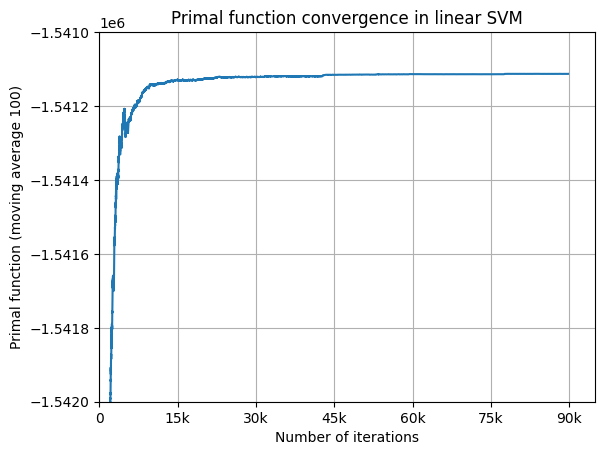

In [105]:
fig, ax = plt.subplots()
ax.plot(range(1, len(loss_ma)+1), loss_ma)

ax.set(xlabel='Number of iterations', ylabel='Primal function (moving average 100)',
       title='Primal function convergence in linear SVM')
ax.grid()
ax.set_ylim(-1.542e6, -1.541e6)
ax.set_xlim(0,95000)
ax.set_xticks(np.arange(0, 105000, 15000), labels = ["0", "15k", "30k", "45k", "60k", "75k", "90k"])

plt.show()

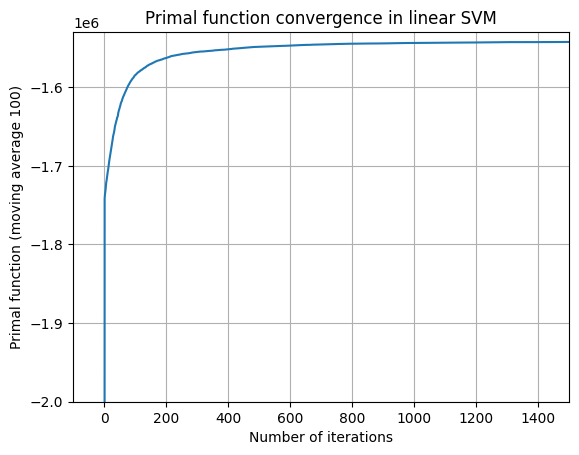

In [106]:
fig, ax = plt.subplots()
ax.plot(range(1, len(loss_ma)+1), loss_ma)

ax.set(xlabel='Number of iterations', ylabel='Primal function (moving average 100)',
       title='Primal function convergence in linear SVM')
ax.grid()
ax.set_ylim(-2e6, -1.53e6)
ax.set_xlim(-100, 1500)
ax.set_xticks(np.arange(0, 1600, 200), )

plt.show()

The values keep growing with more iterations, but after few hundreds the rate diminishes dramatically. Let's check how well does the model perform if we limit ourselves to 1k iterations.

In [101]:
SVM1k = linsvm.LinSVM(max_iter=1000)
SVM1k.fit(x_train, y_train, verbose = True)

prediction = SVM1k.predict(x_test)
accuracy = np.sum(prediction == y_test)/len(y_test)
print(accuracy)

Iteration: 1
Gradient gap: 236465.423254413

Iteration: 2
Gradient gap: 8077.16475743784

Iteration: 3
Gradient gap: 108.01724190908718

Iteration: 4
Gradient gap: 10.630926735570146

Iteration: 5
Gradient gap: 9.783023217178709

Iteration: 6
Gradient gap: 9.884124205243026

Iteration: 7
Gradient gap: 9.500952788490476

Iteration: 8
Gradient gap: 9.32520814759512

Iteration: 9
Gradient gap: 8.831503793226343

Iteration: 10
Gradient gap: 9.086566230450298

Iteration: 11
Gradient gap: 9.802849841365632

Iteration: 12
Gradient gap: 9.89957896319068

Iteration: 13
Gradient gap: 8.192901255052345

Iteration: 14
Gradient gap: 8.889405588550268

Iteration: 15
Gradient gap: 9.076738580488975

Iteration: 16
Gradient gap: 8.66500889703637

Iteration: 17
Gradient gap: 9.36559092598102

Iteration: 18
Gradient gap: 8.486750771957894

Iteration: 19
Gradient gap: 8.7245921888207

Iteration: 20
Gradient gap: 8.65686785684835

Iteration: 21
Gradient gap: 8.59678026905523

Iteration: 22
Gradient gap: 7.

The difference in accuracy is rather negligible, and the time needed to train the model went down almost 4 times (the number of iterations is much less, but the later iterations take less time due to shrinking). It seems that the values of primal function could be used to create an alternative stopping criterion.